# Реализации базы знаний для экспертной системы дифференциальной диагностики офтальмологических заболеваний

## Выбор представления знаний для экспертной системы








### Контекст

Дифференциальная диагностика офтальмологических заболеваний требует систематического анализа большого числа симптомов, которые могут пересекаться между различными патологиями. Для начинающих врачей особенно важно, чтобы процесс принятия решений был прозрачным, последовательным и не зависел от сложных статистических моделей.
В условиях ограниченных данных и отсутствия специализированного оборудования применение вероятностных или машинных методов диагностики оказывается затруднительным: такие подходы требуют больших обучающих выборок, а также создают трудности в интерпретации результатов.
Необходима структура представления знаний, которая позволит формализовать процесс рассуждения врача в виде понятной и проверяемой последовательности логических шагов, основанных на бинарных ответах «Да»/«Нет».

### Факторы, влияющие на принятие решения

- **Интерпретируемость** — необходимость, чтобы логика вывода была полностью прозрачна для пользователя (врача).
- **Ограниченность данных** — невозможность применения статистических методов и машинного обучения из-за малых выборок.
- **Простота модификации** — возможность обновления правил и добавления новых заболеваний без пересмотра всей модели.
- **Детерминированность** — одинаковый результат при одинаковом наборе ответов, что особенно важно для медицинской области.
- **Устойчивость к ошибкам данных** — система должна корректно работать даже при отсутствии некоторых симптомов или неполных ответах.

### Рассмотренные варианты


- **Правила на основе продукционных систем** (если–то): хорошо подходят для описания экспертных знаний, но при большом количестве симптомов и заболеваний создают избыточность и сложность сопровождения; логика связи между симптомами становится неочевидной.
- **Вероятностные модели (например, байесовские сети)**: позволяют учитывать неопределенность симптомов, однако требуют статистических данных и не всегда понятны для интерпретации начинающими специалистами.
- **Деревья решений**: обеспечивают прозрачную структуру, но статичны — при изменении логики диагностики дерево необходимо перестраивать полностью, что усложняет масштабирование.
- **Граф принятия решений**: обобщает дерево решений, позволяя использовать повторяющиеся узлы и связи. Каждая вершина графа представляет вопрос или промежуточное диагностическое состояние, а ребра описывают переход по ответу «Да» или «Нет». Такой подход сохраняет прозрачность логики и одновременно обеспечивает гибкость расширения.

### Результат решения

**Выбран вариант — граф принятия решений.**
Он обеспечивает формализованное и интерпретируемое представление экспертных знаний, позволяя моделировать процесс диагностики как пошаговый переход между состояниями. Алгоритмы обхода графа (DFS, BFS) используются для последовательного движения по вопросам до достижения финального диагноза.
В отличие от вероятностных моделей и деревьев решений, граф допускает использование общих подграфов (например, повторяющихся симптомов для разных заболеваний), что делает систему более компактной и управляемой.

### Последствия

**Положительные**
- Прозрачность и интерпретируемость логики вывода, что повышает доверие со стороны врачей.
- Возможность расширения графа без пересмотра всей модели, добавляя новые связи и узлы.
- Отсутствие зависимости от обучающих выборок и статистических параметров.
- Явная логическая структура, соответствующая клиническому мышлению врача.
- Простота визуализации диагностического процесса и его объяснения пользователю.

**Отрицательные**
- Модель не учитывает вероятности или степень выраженности симптомов.
- При значительном увеличении числа заболеваний граф может стать громоздким и требовать оптимизации структуры.
- Логика диагностики остается строго детерминированной и не адаптируется автоматически к новым данным.

## Источники офтальмологических данных и обоснование их достоверности

### Научные журналы и академические публикации

**Основные издания:**
- «Вестник офтальмологии» — НМИЦ глазных болезней им. Гельмгольца
- «Офтальмология» — Российское общество офтальмологов
- «Офтальмохирургия» — МНТК им. акад. С.Н. Фёдорова
- «Российская детская офтальмология»

**Обоснование достоверности:**
Все указанные журналы входят в перечень ВАК РФ и индексируются в РИНЦ и PubMed.
Каждая публикация проходит двойное слепое рецензирование, экспертную оценку методики и проверку достоверности статистических данных.
Использование этих источников гарантирует, что алгоритмы и диагностические подходы в системе основаны на результатах, признанных научным сообществом.

### Федеральные клинические рекомендации и нормативные документы

**Источники:**
- Минздрав РФ, Национальный медицинский исследовательский центр глазных болезней им. Гельмгольца
- МНТК «Микрохирургия глаза» им. С.Н. Фёдорова

**Обоснование достоверности:**
Клинические рекомендации формируются на основе систематических обзоров мировой литературы (500+ источников), проходят этап экспертного консенсуса (Delphi-метод) и утверждаются профильной комиссией Минздрава РФ.
Каждая рекомендация имеет уровень доказательности (A, B, C) согласно международной системе GRADE.

### Нормативные базы диагностического оборудования

**Примеры:**
- **Cirrus HD-OCT (Carl Zeiss Meditec)** — база данных более 15 000 здоровых пациентов
- **Heidelberg Spectralis (Heidelberg Engineering)** — нормативы структур зрительного нерва и сетчатки
- **RTvue XR Avanti (Optovue)** — эталонные показатели толщины сетчатки по возрастным и этническим группам

**Обоснование достоверности:**
Нормативные базы формируются производителями оборудования на основании обследования больших выборок здоровых людей с учётом пола, возраста и этнических различий.
Данные собираются по единым международным протоколам и обновляются по мере расширения статистики, что обеспечивает объективность сравнения параметров пациента с нормой.

### Международные базы данных и стандарты

**Основные источники:**
- *American Academy of Ophthalmology (AAO)* — клинические протоколы и стандарты диагностики (Preferred Practice Patterns).
- *European Society of Cataract and Refractive Surgeons (ESCRS)* — руководства по хирургическому и медикаментозному лечению заболеваний глаза.
- *Cochrane Library* — систематические обзоры и мета-анализы офтальмологических исследований с оценкой уровня доказательности.
- *ClinicalTrials.gov* — реестр международных клинических испытаний по глаукоме, катаракте, макулодистрофии и другим заболеваниям глаза.

**Обоснование достоверности:**
Международные базы данных обеспечивают доступ к результатам клинических исследований, выполненных по единым протоколам GCP (Good Clinical Practice).
Все представленные материалы проходят предварительную научную экспертизу, статистическую проверку и этическое одобрение.
Каждая публикация и исследование снабжены указанием уровня доказательности (Evidence Level I–III), что позволяет объективно оценивать качество и применимость данных.

## Визуализация базы знаний

In [27]:
!apt-get update
!apt-get install graphviz graphviz-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [28]:
!pip install neo4j networkx matplotlib pygraphviz python-dotenv

In [29]:
from neo4j import GraphDatabase
import networkx as nx
import matplotlib.pyplot as plt
import json
import dotenv
import os

In [30]:
dotenv.load_dotenv()
NEO4J_URI = os.environ.get("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.environ.get("NEO4J_USER", "neo4j")
NEO4J_PASSWORD = os.environ.get("NEO4J_PASSWORD", "neo4j")

In [1]:
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
query = "MATCH (a)-[r]->(b) RETURN a, b, r"
with driver.session() as session:
    records = session.execute_read(lambda tx: list(tx.run(query)))
driver.close()
data = []
for rec in records:
    a = rec["a"]
    b = rec["b"]
    r = rec["r"]
    data.append({
        "a": {
            "identity": a.element_id,
            "labels": list(a.labels),
            "properties": dict(a)
        },
        "b": {
            "identity": b.element_id,
            "labels": list(b.labels),
            "properties": dict(b)
        },
        "r": {
            "identity": r.element_id,
            "type": r.type,
            "properties": dict(r)
        }
    })

NameError: name 'GraphDatabase' is not defined

In [32]:
with open("data.json", "r", encoding="utf-8-sig") as f:
    data = json.load(f)

In [33]:
G = nx.DiGraph()

for item in data:
    a_id = item['a']['identity']
    b_id = item['b']['identity']

    a_label = item['a']['properties'].get('text') or item['a']['properties'].get('name')
    b_label = item['b']['properties'].get('text') or item['b']['properties'].get('name')

    G.add_node(a_id, label=a_label)
    G.add_node(b_id, label=b_label)

    edge_type = item['r']['type']
    G.add_edge(a_id, b_id, label=edge_type, color='green' if edge_type=='ДА' else 'red')

In [36]:
edges = G.edges(data=True)
edge_colors = [edge[2]['color'] for edge in edges]
edge_labels = {(u, v): d['label'] for u, v, d in edges}
pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

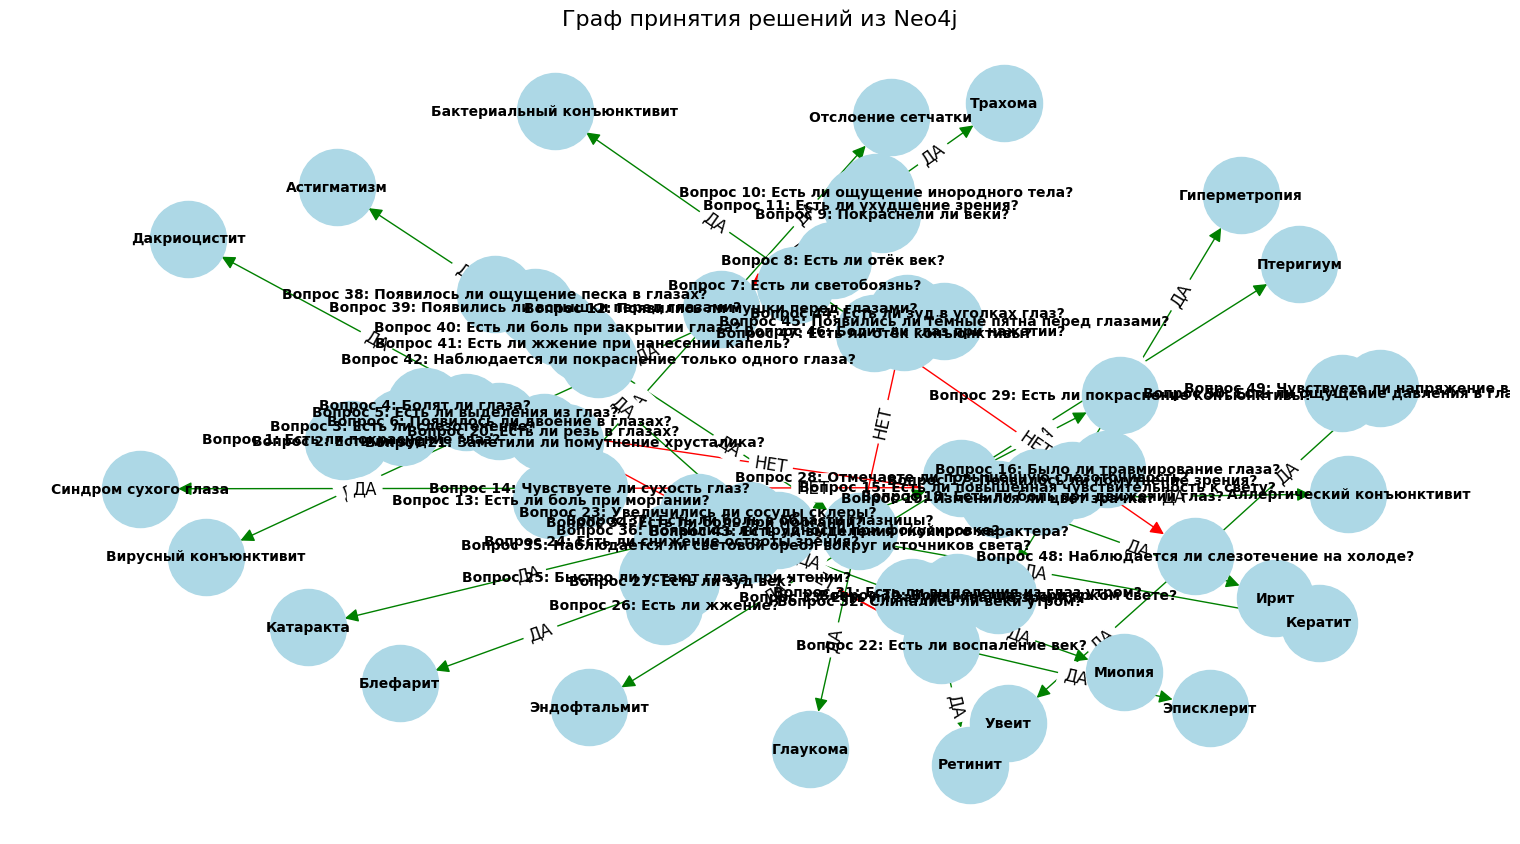

In [37]:
plt.figure(figsize=(15, 8))
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
        node_size=3000, node_color='lightblue', font_size=10, font_weight='bold',
        edge_color=edge_colors, arrows=True, arrowsize=20)

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=12)
plt.title("Граф принятия решений из Neo4j", fontsize=16)
plt.axis('off')
plt.show()